# Ecuación de Schrödinger

## La ecuación a resolver es
### $$
i \hbar \frac{\partial \psi}{\partial t} = - \frac{\hbar^2}{2 m}  \nabla^2 \psi
$$

### Eligiendo $\hbar=1$ y $m=\frac{1}{2}$ :

### $$
i \frac{\partial u}{\partial t} = - \nabla^2 u
$$

### Usando el método de Crank-Nicolson para discretizar en el tiempo, se transforma en el problema
### $$
i (u_{n+1}-u_n) = - dt \ \frac{1}{2} \nabla^2 (u_{n+1}+u_n)
$$

### Si u es autofunción del laplaciano $\nabla^2 u = \lambda u = -\frac{c}{\Delta x^2} u $

### Entonces
### $$
u_{n+1} \big(i+\frac{dt\ \lambda}{2} \big) = u_{n} \big(i-\frac{dt\ \lambda}{2} \big)
$$

### El factor de amplificación es
### $$
\Big|\frac {i-dt\ \lambda\ /\ 2} {i+dt\ \lambda\ /\ 2}\Big| = 1
$$

### Para recapitular, el problema queda:
### $$
2 i \ u_{n+1} + dt \ \nabla^2 u_{n+1} = 2  i \ u_{n} - dt \ \nabla^2 u_{n}
$$

### Que tiene la siguiente formulación débil:
### $$
\int \big( 2 i\ v \ u_{n+1} + dt\ \nabla v \cdot \nabla u_{n+1} \big) d \Omega = \int \big( 2 i\ v\ u_{n} - dt\ \nabla v \cdot \nabla u_{n} \big) d \Omega
$$

In [1]:
using Gridap
using GridapMakie, GLMakie
#using FileID
using GridapGmsh

In [2]:
n=100
domain = (0,1,0,1)
partition = (n,n)
model = CartesianDiscreteModel(domain,partition)

CartesianDiscreteModel()

In [3]:
T=0.15
num_steps=101
dt = T/(num_steps-1)

0.0015

In [4]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"diri_all",[1,2,3,4,5,6,7,8]);


In [5]:
order = 2
degree = order
Ωn = Triangulation(model)
dΩn = Measure(model,degree)

Measure()

In [6]:
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,labels=labels,dirichlet_tags=["diri_all"],conformity=:H1,vector_type=Vector{ComplexF64})
U = TrialFESpace(V,0.0)

TrialFESpace()

In [7]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

### Seteo la condición inicial

In [8]:
function particle(x,par,norm)
    r0,xi,k,p = par
    
    r = sqrt((x[1]-xi[1])^2 + (x[2]-xi[2])^2)
    kx = 2*pi*(k[1]*(x[1]-xi[2]) + k[2]*(x[2]-xi[2]))
    if r < r0
        return (1/norm)*((r-r0)^p-(r-r0)^p * (4^(2p)*exp(im*kx)))
    else 
        return 0.0+0.0*im
    end
end

function gaussian(x,par,norm)
    xi,σ = par
    
    r = sqrt((x[1]-xi[1])^2 + (x[2]-xi[2])^2)
    
    return (1/norm)*exp(-(r)^2/σ)
    
end

gaussian (generic function with 1 method)

In [9]:
function L2_norm(u)
    return sqrt(sum(∫(real(u)*real(u)+imag(u)*imag(u))dΩn))
end
function Heaviside(x,x0,left)
    if left==true
        if x[1]<x0
            return 1.0
        else
            return 0.0
        end
    else
        if x[1]>x0
            return 1.0
        else
            return 0.0
        end
    end
    
end
function Heavi_Int(u,H)
    return sum(∫(real(H)*(real(u)*real(u)+imag(u)*imag(u)))dΩn)
end
function L2_norm_ds(u)
    return sqrt(sum(∫(real(u)*real(u)+imag(u)*imag(u))dΩ))
end

L2_norm_ds (generic function with 1 method)

In [28]:
parameters = (0.4,[0.25,0.25],[-3,-4],4)
u_temp(x)=particle(x,parameters,1)

u_temp (generic function with 1 method)

In [29]:
u_n_temp = interpolate_everywhere(u_temp,V);
temp_norm=L2_norm(u_n_temp)

177.2931201442712

### Voy a normalizar la función de onda inicial en todos los ejemplos, veremos luego que tan bien se conserva esta norma

In [30]:
parameters = (0.4,[0.25,0.25],[-3,-4],4)
u_0(x) = particle(x,parameters,temp_norm)
u_n = interpolate_everywhere(u_0,V);
println(L2_norm(u_n))

1.000000000000001


In [31]:
a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u)dΩn
u_n = interpolate_everywhere(u_0,V)
t = 0
#n_save = 5 #cada cuantas iteraciones guardo
Prob = zeros(num_steps)
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im*2*v*u_n)dΩn
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n=uh
    Prob[istep]=L2_norm(uh)
    #if istep % n_save == 0
    writevtk(Ωn,"images/wave_function_$(lpad(istep,3,'0'))",cellfields=["wavefunction_real" => real(uh),"wavefunction_imag" => imag(uh)])
    #end
end

 36.846982 seconds (47.61 M allocations: 20.943 GiB, 3.80% gc time, 4.91% compilation time)


In [32]:
Prob

101-element Vector{Float64}:
 1.0000449580520459
 1.0000449580520494
 1.000044958052049
 1.000044958052044
 1.000044958052043
 1.000044958052038
 1.0000449580520343
 1.0000449580520343
 1.0000449580520319
 1.0000449580520299
 1.0000449580520274
 1.0000449580520268
 1.0000449580520245
 ⋮
 1.0000449580518973
 1.0000449580518966
 1.0000449580518949
 1.0000449580518933
 1.0000449580518904
 1.0000449580518904
 1.0000449580518873
 1.000044958051885
 1.0000449580518838
 1.0000449580518813
 1.0000449580518804
 1.0000449580518773

## Probemos con una autofunción como valor inicial

### Las autoenergías (pares) de la partícula confinada a una caja de largo L son
### $$
E_{n_x,n_y} =\frac{( 2n_x+1)^{2} \pi ^{2} \hbar ^{2}}{2mL^{2}} + \frac{( 2n_y+1)^{2} \pi ^{2} \hbar ^{2}}{2mL^{2}}
$$

### Con sus autofunciones respectivas:
### $$
\psi_n (x,y,t) =C \ \cos \big(n_x \ \frac{\pi}{L}x \big) \ \cos \big(n_y \ \frac{\pi}{L}y \big) \ e^{-i \ E_n \ t \ / \ \hbar }
$$

### En particular para $n_x=n_y=1$
### $$
E=\frac{3^{2} \pi ^{2} \hbar ^{2}}{mL^{2}}
$$
### y usando $m=1/2 , \hbar=1, L=1$
### $$
E=2 \ 3^{2} \pi ^{2} 
$$
### $$
\psi_n (x,y,t) =C \ \cos \big(3 \ \pi x \big) \ \cos \big(3 \ \pi y \big) \ e^{-2i  \ 3^{2} \pi ^{2}  \ t}
$$

In [10]:
function sqreigen(x,L,norm)
    return (1/norm)*(cos(3*π/L * (x[1]+L/2)))*(cos(3*π/L * (x[2]+L/2)))
end

sqreigen (generic function with 1 method)

In [28]:
function error_at_dt(u,u_t)
    return sqrt(sum(∫(abs(real(u)*real(u)-real(u_t)*real(u_t))+abs(imag(u)*imag(u)-imag(u_t)*imag(u_t)))dΩn))
end
function error_real_at_dt(u,u_t)
    return sqrt(sum(∫(abs(real(u)*real(u)-real(u_t)*real(u_t)))dΩn))
end
function error_imag_at_dt(u,u_t)
    return sqrt(sum(∫(abs(imag(u)*imag(u)-imag(u_t)*imag(u_t)))dΩn))
end
function linear_error_real_at_dt(u,u_t)
    return sum(∫(abs(real(u)-real(u_t)))dΩn)
end

linear_error_real_at_dt (generic function with 1 method)

In [29]:
T=0.15
num_steps=501
dt = T/(num_steps-1)

0.0003

In [30]:
u_temp2(x)=sqreigen(x,1,1)
u_n_temp2 = interpolate_everywhere(u_temp2,V);
temp_norm2=L2_norm(u_n_temp2)

0.49999986306915584

In [31]:
u_02(x) = sqreigen(x,1,temp_norm2)
u_n2 = interpolate_everywhere(u_02,V);
println(L2_norm(u_n2))

1.0


In [32]:
a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u)dΩn
u_n2 = interpolate_everywhere(u_02,V)
u_tn = interpolate_everywhere(u_02,V)
freq=2*3.0*3.0*π*π # 2 n^2 pi^2 
t = 0
n_save = 5 #cada cuantas iteraciones guardo
Prob = zeros(num_steps)
err=zeros(num_steps)
err_real=zeros(num_steps)
err_imag=zeros(num_steps)
lin_err_real=zeros(num_steps)
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n2) * dt + im*2*v*u_n2)dΩn
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n2=uh
    Prob[istep]=L2_norm(uh)
    if istep % n_save == 0
    writevtk(Ωn,"images/wave_eigenfunction_$(lpad(istep,3,'0'))",cellfields=["waveeigenfunction_real" => real(uh),"waveeigenfunction_imag" => imag(uh),
            "exacteigenfunction_real" => real(u_tn*exp(-1im*freq*t)),"exacteigenfunction_imag" => imag(-u_tn*exp(-1im*freq*t))])
    err[istep]=error_at_dt(uh,u_tn*exp(-1im*freq*t)) #el error en este step (integrado) lo guardo.
    err_real[istep]=error_real_at_dt(uh,u_tn*exp(-1im*freq*t)) #el error de la parte real en este step (integrado) lo guardo.
    err_imag[istep]=error_imag_at_dt(uh,u_tn*exp(-1im*freq*t))
    lin_err_real[istep]=linear_error_real_at_dt(uh,u_tn*exp(-1im*freq*t))
    end
end
Prob

171.200145 seconds (79.40 M allocations: 90.309 GiB, 2.23% gc time, 1.28% compilation time)


501-element Vector{Float64}:
 0.9999999999999997
 0.999999999999999
 0.9999999999999987
 0.9999999999999984
 0.9999999999999987
 0.9999999999999993
 0.9999999999999972
 1.0000000000000004
 1.0000000000000029
 1.000000000000002
 0.9999999999999973
 1.000000000000001
 0.9999999999999933
 ⋮
 1.0000000000000007
 0.9999999999999979
 1.0
 0.9999999999999981
 0.9999999999999999
 0.9999999999999991
 0.9999999999999983
 0.9999999999999992
 0.9999999999999963
 0.9999999999999978
 0.999999999999998
 0.9999999999999969

![image.png](Eigen.png)

In [33]:
T=0.15
num_steps2=1001
dt = T/(num_steps2-1)
a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u)dΩn
u_n2 = interpolate_everywhere(u_02,V)
u_tn = interpolate_everywhere(u_02,V)
freq=2*3.0*3.0*π*π # 2 n^2 pi^2 
t = 0
n_save2 = 10 #cada cuantas iteraciones guardo
Prob = zeros(num_steps2)
err2=zeros(num_steps2)
err_real2=zeros(num_steps2)
err_imag2=zeros(num_steps2)
lin_err_real2=zeros(num_steps2)
@time for istep in 1:num_steps2
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n2) * dt + im*2*v*u_n2)dΩn
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n2=uh
    Prob[istep]=L2_norm(uh)
    if istep % n_save2 == 0
    #writevtk(Ωn,"images/wave_eigenfunction_$(lpad(istep,3,'0'))",cellfields=["waveeigenfunction_real" => real(uh),"waveeigenfunction_imag" => imag(uh),
    #        "exacteigenfunction_real" => real(u_tn*exp(-1im*freq*t)),"exacteigenfunction_imag" => imag(-u_tn*exp(-1im*freq*t))])
    err2[istep]=error_at_dt(uh,u_tn*exp(-1im*freq*t)) #el error en este step (integrado) lo guardo.
    err_real2[istep]=error_real_at_dt(uh,u_tn*exp(-1im*freq*t)) #el error de la parte real en este step (integrado) lo guardo.
    err_imag2[istep]=error_imag_at_dt(uh,u_tn*exp(-1im*freq*t))
    lin_err_real2[istep]=linear_error_real_at_dt(uh,u_tn*exp(-1im*freq*t))
    end
end
Prob

330.190109 seconds (59.16 M allocations: 170.648 GiB, 1.55% gc time, 0.01% compilation time)


1001-element Vector{Float64}:
 0.9999999999999998
 1.000000000000001
 1.000000000000001
 0.9999999999999972
 1.0000000000000018
 0.9999999999999967
 1.0000000000000009
 0.999999999999997
 0.9999999999999989
 1.0000000000000024
 0.9999999999999947
 0.9999999999999972
 0.9999999999999962
 ⋮
 0.99999999999999
 0.9999999999999939
 0.9999999999999908
 0.9999999999999921
 0.9999999999999944
 0.9999999999999937
 0.9999999999999951
 0.9999999999999933
 0.9999999999999938
 0.9999999999999947
 0.9999999999999908
 0.9999999999999918

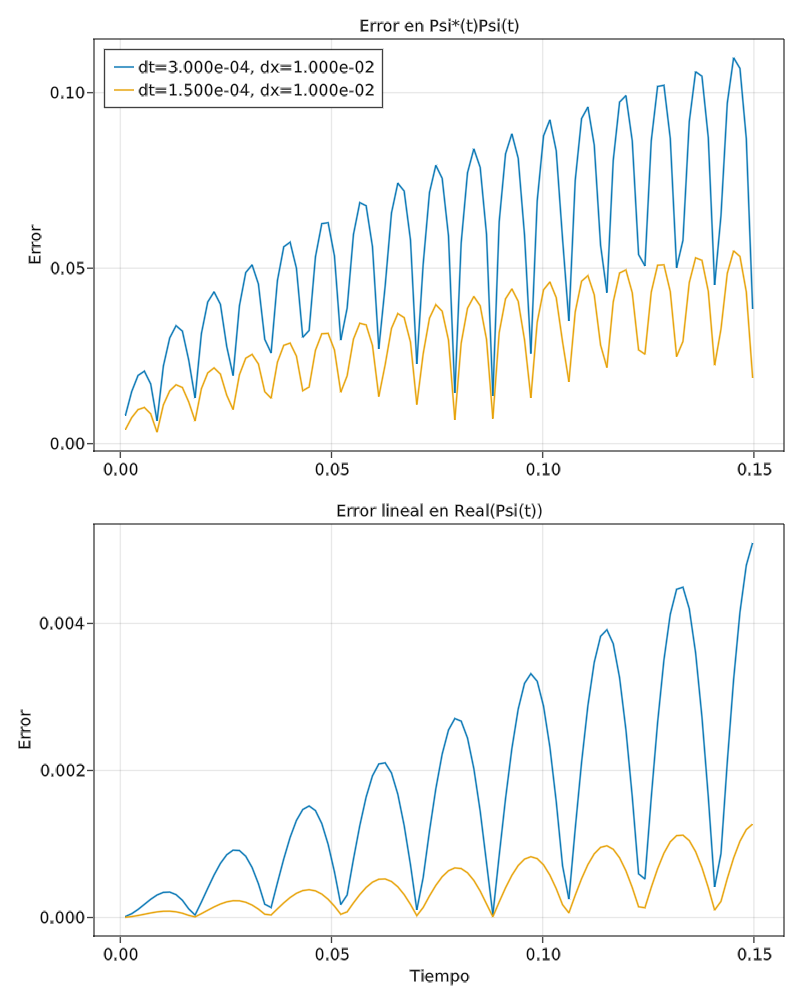

In [37]:
using Printf
dt = T/(num_steps-1)
dt2 = T/(num_steps2-1)
time=[(i-1)*dt for i in n_save:n_save:num_steps]
fig = Figure(resolution = (800, 1000))
ax=Axis(fig[1, 1])
lines!(ax,time,err[n_save:n_save:end],label="dt=$(@sprintf("%.3e", dt)), dx=$(@sprintf("%.3e", 1/n))")
lines!(ax,time,err2[n_save2:n_save2:end],label="dt=$(@sprintf("%.3e", dt2)), dx=$(@sprintf("%.3e", 1/n))")
ax.title="Error en Psi*(t)Psi(t)"
ax.ylabel="Error"
axislegend(ax,position= :lt)
ax2=Axis(fig[2, 1])
lines!(ax2,time,lin_err_real[n_save:n_save:end])
lines!(ax2,time,lin_err_real2[n_save2:n_save2:end])
ax2.title="Error lineal en Real(Psi(t))"
ax2.xlabel="Tiempo"
ax2.ylabel="Error"
fig

## ¿y si agregamos un potencial?
### $$
i \hbar \frac{\partial \psi}{\partial t} = - \frac{\hbar^2}{2 m}  \nabla^2 \psi + V(x,y) \psi
$$

### $$
i \frac{\partial u}{\partial t} = - \nabla^2 u + P(x,y) u
$$

### Se transforma en el problema
### $$
i (u_{n+1}-u_n) = - dt * \frac{1}{2} \nabla^2 (u_{n+1}+u_n) + dt * P(x,y) (u_{n+1}+u_n)
$$

### Entonces
### $$
u_{n+1} \big(i+dt \big( \frac{ \lambda}{2}-P(x,y) \big) \big) = u_{n} \big(i-dt \big(\frac{ \lambda}{2}-P(x,y) \big)\big)
$$

### El factor de amplificación es
### $$
\Big|\frac {i-dt \lambda/2 +P} {i+dt \lambda / 2 -P}\Big| = 1
$$

### El problema tiene la siguiente formulación débil:
### $$
\int \big( 2 \ i\ v\ u_{n+1} + dt\ \nabla v \cdot \nabla u_{n+1} + dt\ v\ u_{n+1}\ P \big) d \Omega = \int \big( 2 i\ v\ u_{n} - dt\ \nabla v \cdot \nabla u_{n} - dt\ v\ u_{n}\ P \big) d \Omega
$$

## Probemos una barrera de potencial

In [12]:
parameters = (0.2,[0.25,0.5],[-1.5,0],4)
u_temp(x)=particle(x,parameters,1)
u_n_temp = interpolate_everywhere(u_temp,V);
temp_norm=L2_norm(u_n_temp)
u_0(x) = particle(x,parameters,temp_norm)
u_n = interpolate_everywhere(u_0,V);
println(L2_norm(u_n))

1.0000000000000002


In [23]:
#defino el potencial
strenght = 2200 #1200
function pp(x)
    if (x[1]>0.47 && x[1]<0.53)
        return strenght
    else 
        return 0.0
    end
end

a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u + u*v*pp*dt)dΩn
u_n = interpolate_everywhere(u_0,V)
#esto es para calcular probabilidades del lado izquierdo y derecho de la barrera
hevL(x)=Heaviside(x,0.5,true)
HeviL = interpolate_everywhere(hevL,V)
hevR(x)=Heaviside(x,0.5,false)
HeviR = interpolate_everywhere(hevR,V)
ProbL=zeros(num_steps)
ProbR=zeros(num_steps)
t = 0
#n_save = 5 #cada cuantas iteraciones guardo
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im*2*v*u_n - u_n*v*pp*dt)dΩn
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n=uh
    #if istep % n_save == 0
    writevtk(Ωn,"images/wave_function_potential2_$(lpad(istep,3,'0'))",cellfields=["wavefunction_potential2_real" => real(uh),"wavefunction_potential2_imag" => imag(uh)])
    
    ProbL[istep]=Heavi_Int(uh,HeviL)
    ProbR[istep]=Heavi_Int(uh,HeviR)
    #end
end
p_vtk = interpolate_everywhere(pp,V)
writevtk(Ωn,"images/potential2",cellfields=["potential2" => real(p_vtk)])

209.429579 seconds (261.62 M allocations: 106.806 GiB, 2.89% gc time, 3.79% compilation time)


(["images/potential2.vtu"],)

![Image](Barrier.png) 

In [24]:
ProbL+ProbR

501-element Vector{Float64}:
 0.9999999999693269
 0.999999997852326
 0.9999999660721289
 0.9999997809100172
 0.9999992050441582
 0.9999971267787702
 0.9999832874617582
 0.9999077418622367
 0.9996434817896772
 0.9990620987397513
 0.9983106110910249
 0.9979161533691236
 0.998200163326268
 ⋮
 0.9997199333122899
 0.9997624898268441
 0.9997312979800852
 0.9996770457882747
 0.9996668934414505
 0.9997289277982246
 0.9998042245927887
 0.9998444148072113
 0.999830862808121
 0.9998221547876723
 0.9998136796871616
 0.9998002615843288

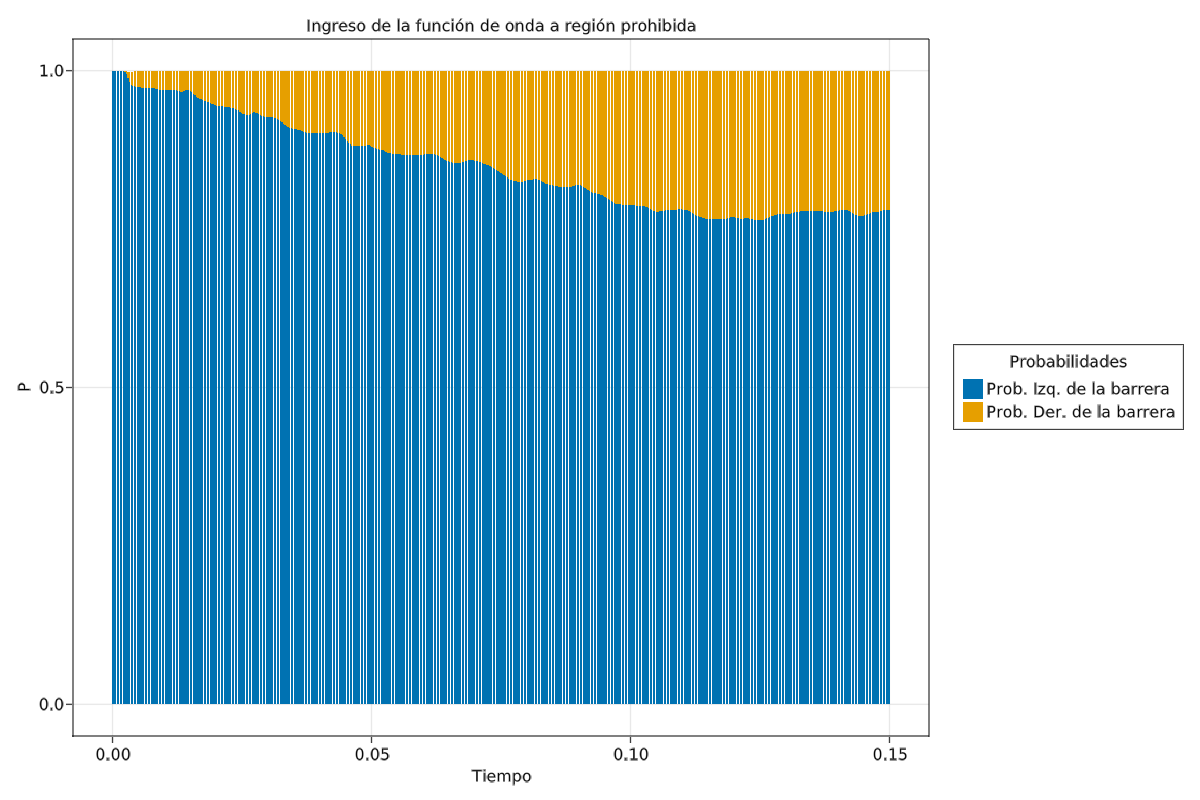

In [25]:
colors = Makie.wong_colors()
time=[(i-1)*dt for i in 1:num_steps]
a_vec=[1 for i in 1:num_steps]
b_vec=[2 for i in 1:num_steps]
tbl = (x = vcat(time,time),
       height = vcat(ProbL,ProbR),
       grp = vcat(a_vec,b_vec),
       )
fig = Figure(resolution = (1200, 800))
ax=Axis(fig[1, 1])
barplot!(ax,tbl.x, tbl.height,stack = tbl.grp,color = colors[tbl.grp])
ax.title="Ingreso de la función de onda a región prohibida"
ax.xlabel="Tiempo"
ax.ylabel="P"
labels = ["Prob. Izq. de la barrera", "Prob. Der. de la barrera"]
elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]
title = "Probabilidades"

Legend(fig[1,2], elements, labels, title)
fig

## Probemos el potencial armónico bidimensional

### El problema es 
### $$
i \hbar \frac{\partial \psi}{\partial t}(x,y) = - \frac{\hbar^2}{2 m}  \nabla^2 \psi(x,y) + \frac{1}{2} m \omega^2 (x^2+y^2) \psi(x,y)
$$

### Que para una autofunción del hamiltoniano:
### $$
E \psi(x,y) = - \frac{\hbar^2}{2 m}  \nabla^2 \psi(x,y) + \frac{1}{2} m \omega^2 (x^2+y^2) \psi(x,y)
$$
### Adimensionalizamos 
### $$
x = \sqrt{\frac{m \omega}{\hbar}} x'
$$
### $$
y = \sqrt{\frac{m \omega}{\hbar}} y'
$$
### $$
\varepsilon = \frac{E}{\hbar \omega}
$$
### Obtenemos
### $$
\varepsilon \ \psi(x,y) = - \frac{1}{2}  \nabla^2 \psi(x,y) + \frac{1}{2} (x^2+y^2) \psi(x,y)
$$

### Esta ecuación tiene soluciones de la forma:
### $$
\psi(x,y) = C \ H_{nx}(x) \ H_{ny}(y) \ e^{-(x^2+y^2) \ / \ 2}
$$
### Donde $H_{n}$ Es el polinomio de Hermite de orden n
### $$
n_x \ , \ n_y = 0,1,2,\dots
$$
### $$
\varepsilon = n_x+n_y+1
$$

### Luego, la función dependiente del tiempo es:
### $$
\psi(x,y,t) = C \ H_{nx}(x) \ H_{ny}(y) \ e^{-(x^2+y^2) \ / \ 2} \ e^{-i \ \varepsilon \ \omega  \ t}
$$

In [38]:
function harmonic_eigen(x,L,n_x,n_y,norm)
    if (n_x==1 && n_y==1)
        return (1/norm)*(x[1]-L/2)*(x[2]-L/2)*exp(-(x[1]-L/2)^2/2)*exp(-(x[2]-L/2)^2/2)+0.0im
    end
    if (n_x==0 && n_y==1)
        return (1/norm)*(x[2]-L/2)*exp(-(x[1]-L/2)^2/2)*exp(-(x[2]-L/2)^2/2)+0.0im
    end
    if (n_x==1 && n_y==0)
        return (1/norm)*(x[1]-L/2)*exp(-(x[1]-L/2)^2/2)*exp(-(x[2]-L/2)^2/2)+0.0im
    end
end

harmonic_eigen (generic function with 1 method)

In [39]:
n=100
L=20
domain = (0,L,0,L)
partition = (n,n)
model = CartesianDiscreteModel(domain,partition)
T=pi
num_steps=1001
dt = T/(num_steps-1)
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"diri_all",[1,2,3,4,5,6,7,8]);
order = 2
degree = order
Ωn = Triangulation(model)
dΩn = Measure(model,degree)
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,labels=labels,dirichlet_tags=["diri_all"],conformity=:H1,vector_type=Vector{ComplexF64})
U = TrialFESpace(V,0.0)
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [40]:
n_x=1 #dar valores 0 o 1
n_y=1 
ε_xy=n_x+n_y+1
ω=2 #uso ω=2, ħ=1 y m=1/2 

u_temp(x)=harmonic_eigen(x,L,n_x,n_y,1)
u_n_temp = interpolate_everywhere(u_temp,V);
temp_norm=L2_norm(u_n_temp)
u_0(x) = harmonic_eigen(x,L,n_x,n_y,temp_norm)
u_n = interpolate_everywhere(u_0,V);
println(L2_norm(u_n))

0.9999999999999988


In [16]:
#function error_at_dt(u,u_t)
#    return sqrt(sum(∫(abs(real(u)*real(u)+imag(u)*imag(u)-real(u_t)*real(u_t)-imag(u_t)*imag(u_t)))dΩn))
#end
#function error_real_at_dt(u,u_t)
#    return sqrt(sum(∫(abs(real(u)*real(u)-real(u_t)*real(u_t)))dΩn))
#end

In [41]:
#defino el potencial

p(x)= (x[1]-L/2)^2 + (x[2]-L/2)^2

a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u + u*v*p*dt)dΩn
u_n = interpolate_everywhere(u_0,V)

Prob2= zeros(num_steps)
err=zeros(num_steps)
err_real=zeros(num_steps)
lin_err_real=zeros(num_steps)
t = 0
u_t(x) = harmonic_eigen(x,L,n_x,n_y,temp_norm)
u_tn = interpolate_everywhere(u_0,V); #Esta es la solución exacta...
n_save = 5 #cada cuantas iteraciones guardo
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im*2*v*u_n - u_n*v*p*dt)dΩn
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n=uh
    
    if istep % n_save == 0
    Prob2[istep]=L2_norm(uh) #checkeo la norma en cada step
    writevtk(Ωn,"images/wave_function_potential_$(lpad(istep,3,'0'))",cellfields=[
            "wavefunction_potential_real" => real(uh),"wavefunction_potential_imag" => imag(uh),
            "exact_potential_real" => real(u_tn*exp(-1im*ω*ε_xy*t)),"exact_potential_imag" => imag(u_tn*exp(-1im*ω*ε_xy*t)) #grabo la exacta, con oscilación dependiente de t
            ])
    err[istep]=error_at_dt(uh,u_tn*exp(-1im*ω*ε_xy*t)) #el error en este step (integrado) lo guardo.
    err_real[istep]=error_real_at_dt(uh,u_tn*exp(-1im*ω*ε_xy*t)) #el error de la parte real en este step (integrado) lo guardo.
    lin_err_real[istep]=linear_error_real_at_dt(uh,u_tn*exp(-1im*ω*ε_xy*t))
    end

end
p_vtk = interpolate_everywhere(p,V)
writevtk(Ωn,"images/potential",cellfields=["potential" => real(p_vtk)])

369.502207 seconds (529.83 M allocations: 187.055 GiB, 1.97% gc time, 1.72% compilation time)


(["images/potential.vtu"],)

In [33]:
#Prob2[n_save:n_save:end]

![image.png](HarmonicEigen.png)

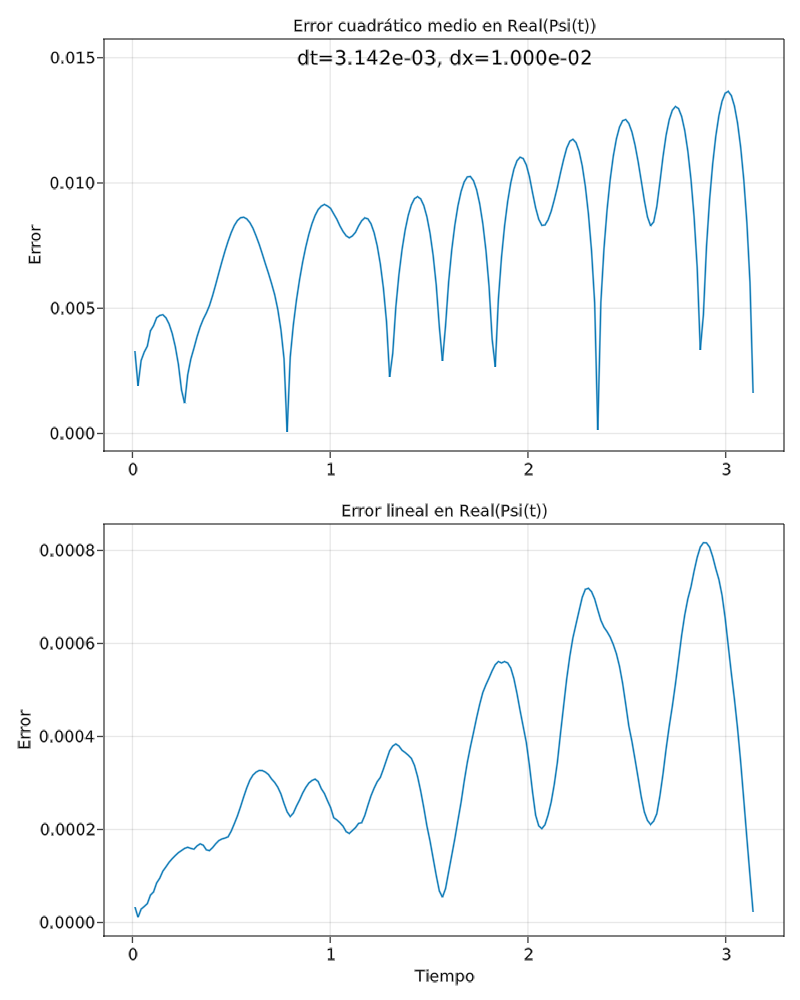

In [42]:
#using Printf
time=[(i-1)*dt for i in n_save:n_save:num_steps]
fig = Figure(resolution = (800, 1000))
ax=Axis(fig[1, 1])
lines!(ax,time,err_real[n_save:n_save:end])
text!(ax,"dt=$(@sprintf("%.3e", dt)), dx=$(@sprintf("%.3e", 1/n))", position = (pi/2, 0.015), align = (:center, :center))
ax.title="Error cuadrático medio en Real(Psi(t))"
ax.ylabel="Error"
ax2=Axis(fig[2, 1])
lines!(ax2,time,lin_err_real[n_save:n_save:end])
ax2.title="Error lineal en Real(Psi(t))"
ax2.xlabel="Tiempo"
ax2.ylabel="Error"
fig


## Ahora probemos en alguna geometría distinta, por ejemplo la doble rendija.

In [33]:
using gmsh
include("Mesh_creator.jl")

make_model (generic function with 1 method)

In [34]:
grid_type = "double_slit"
par = (6.0, 6.0, 0.2, 0.6 ,0.3, 0.02)
model = make_model(grid_type, par)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 16 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.00299096s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 4.92441s, CPU 4.92188s)
Info    : 102142 nodes 204300 elements
Info    : Writing 'models/double_slit.msh'...
Info    : Done writing 'models/double_slit.msh'
Info   

UnstructuredDiscreteModel()

In [35]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)
#
surf = BoundaryTriangulation(model,tags="ext")
dsurf = Measure(surf,degree)

Measure()

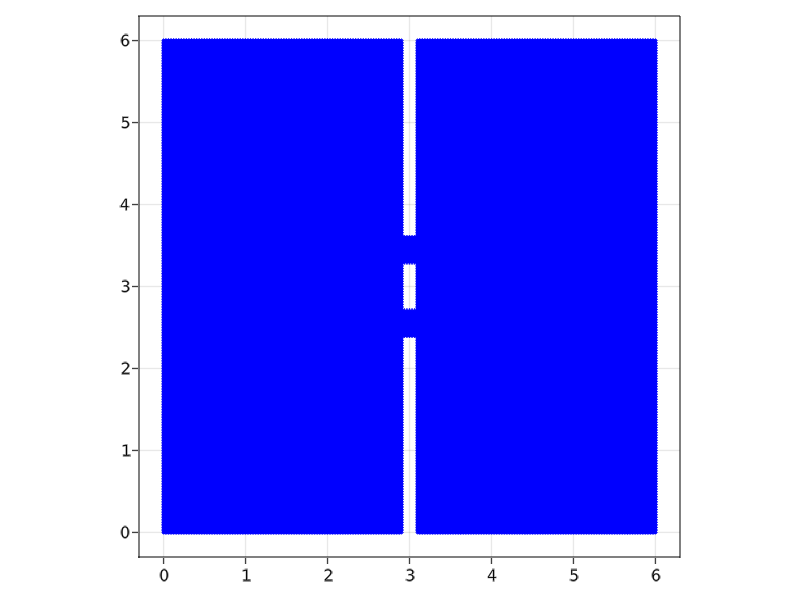

In [36]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

In [37]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = ["ext" , "wall"])
U = TrialFESpace(V,[0.0,0.0])

TrialFESpace()

In [38]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [39]:
parameters = (0.4,[0.35,3.0],[-4,0],4)
u_temp(x)=particle(x,parameters,1)
u_n_temp = interpolate_everywhere(u_temp,V);
temp_norm=L2_norm_ds(u_n_temp)
u_0(x)=particle(x,parameters,temp_norm)
u_n = interpolate_everywhere(u_0,V);
println(L2_norm_ds(u_n))

0.9999999999999999


In [40]:
T=0.2
num_steps=501
dt = T/(num_steps-1)

0.0004

In [41]:
a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + im*2*v*u)dΩ
u_n = interpolate_everywhere(u_0,V)
t = 0
n_save = 5 #cada cuantas iteraciones guardo
Probds = zeros(num_steps)
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im*2*v*u_n)dΩ
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n=uh
    Probds[istep]=L2_norm_ds(uh)
    if istep % n_save == 0
        writevtk(Ω,"images/wave_function_ds_$(lpad(istep,3,'0'))",cellfields=["wavefunction_ds_real" => real(uh),"wavefunction_ds_imag" => imag(uh)])
    end
end

3146.448494 seconds (665.02 M allocations: 945.836 GiB, 3.21% gc time, 0.28% compilation time)


In [42]:
Probds

501-element Vector{Float64}:
 1.0000000072347943
 1.0000000072347952
 1.000000007234795
 1.0000000072347932
 1.0000000072347928
 1.0000000072347945
 1.000000007234793
 1.0000000072347923
 1.0000000072347945
 1.000000007234793
 1.0000000072347923
 1.0000000072347932
 1.0000000072347932
 ⋮
 1.0000000072348048
 1.0000000072348072
 1.0000000072348159
 1.0000000072348036
 1.000000007234813
 1.0000000072348092
 1.0000000072348159
 1.0000000072348105
 1.0000000072347985
 1.0000000072348094
 1.0000000072348034
 1.0000000072348032

![Image](wavePattern1.png) 

# Implemento disipasión en las paredes exteriores, para una mejor visualización:


### La atenuación es simplemente reemplazar $i$ en:
### $$
u_{n+1} \big(i+\frac{dt\ \lambda}{2} \big) = u_{n} \big(i-\frac{dt\ \lambda}{2} \big)
$$

### por $ \big(i \ g(x,y) + f(x,y) \big)$ :
### $$
u_{n+1} \Big(i \ g(x,y) + f(x,y)+\frac{dt\ \lambda}{2} \Big) = u_{n} \Big(i \ g(x,y) + f(x,y)-\frac{dt\ \lambda}{2} \Big)
$$
### Donde $f(x,y)$ es una función que vale 1 cerca de los bordes y cero en el centro, y $g(x,y)=1-f(x,y)$

In [43]:
function aten_coef(x)
    po=100.0
    L=6.0
    return (1.0/(po*x[1]*x[1]+1.0)+1.0/(po*(x[1]-L)*(x[1]-L)+1.0))+(1.0/(po*x[2]*x[2]+1.0)+1.0/(po*(x[2]-L)*(x[2]-L)+1.0))+0im
end
function anti_aten_coef(x)
    po=100.0
    L=6.0
    return 1-(1.0/(po*x[1]*x[1]+1.0)+1.0/(po*(x[1]-L)*(x[1]-L)+1.0))-(1.0/(po*x[2]*x[2]+1.0)+1.0/(po*(x[2]-L)*(x[2]-L)+1.0))+0im
end

anti_aten_coef (generic function with 1 method)

In [44]:
aten = interpolate_everywhere(aten_coef,V)
writevtk(Ω,"images/aten",cellfields=["atenuation" => real(aten)])
antiaten = interpolate_everywhere(anti_aten_coef,V)

SingleFieldFEFunction():
 num_cells: 202524
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 1120370831452862432

In [45]:
a(u,v) = ∫(∇(v) ⋅ ∇(u) * dt + (im*antiaten+aten)*2*v*u)dΩ
u_n = interpolate_everywhere(u_0,V)
t = 0
n_save = 5 #cada cuantas iteraciones guardo
Probds = zeros(num_steps)
@time for istep in 1:num_steps
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + (im*antiaten+aten)*2*v*u_n)dΩ
    op = AffineFEOperator(a,b,U,V)
    uh=solve(solver,op)
    u_n=uh
    Probds[istep]=L2_norm_ds(uh)
    if istep % n_save == 0
        writevtk(Ω,"images/wave_function_ds2_$(lpad(istep,3,'0'))",cellfields=["wavefunction_ds2_real" => real(uh),"wavefunction_ds2_imag" => imag(uh)])
    end
end

3267.337497 seconds (679.07 M allocations: 947.343 GiB, 3.17% gc time, 0.29% compilation time)


In [46]:
Probds

501-element Vector{Float64}:
 0.9698695810079135
 0.9448877338416872
 0.923691337994291
 0.905395209241963
 0.8893868793166403
 0.8752242061731778
 0.8625775827753129
 0.8511949067436744
 0.8408794949499492
 0.8314753751210443
 0.8228566688781492
 0.8149201800479581
 0.8075806875022418
 ⋮
 0.16539567886238685
 0.1649092086203644
 0.16442528941014686
 0.16394387723248732
 0.16346493311700308
 0.1629884249843057
 0.1625143279459712
 0.16204262417287188
 0.16157330410657927
 0.1611063654105757
 0.16064181305298106
 0.16017965891017363

![Image](wavePattern_diss.png) 

![Image](Slice.png) 